# The Goal
To create and improve a Convolutional Neural Network that can correctly identify hand-written, single-digit numbers. 

## First Step: Naïve Model Training
I start by training a model to do the task we want, without worrying about performance. I will improve the performance as much as possible later. 

### Data Preparation
( _See [data.py](./data.py)_ )

I am using the standard MNIST handwritten digit database. This includes a training dataset and a testing dataset. The data preparation step does two important things:
1. Load the database into iterators with a simple list-of-numbers format that can be passed directly to the neural network.
2. Augment the dataset. The images are very clear, centered, and crisp; this won't be the case in real life. I can try to get the dataset closer to real life by augmenting it with various distortions: rotations, skews, crops, noise, etc.

I don't want the model to ONLY learn from augmented images. I want it to be able to _generalize_ to any kind of sample. So, the data will be _partially augmented_: only a portion will go through the transformations. The other portion will remain clear and simple. I don't know the proper ratio yet; I will play with different ratios after I've set up a training loop.

### Data Exploration
Let's look at some of the handwritten digits. 

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import math
from PIL import Image
from model import model_options
from data import get_training_data, get_testing_data

trainloader = get_training_data(model_options['batch_size'], sample_augmentation_ratio=model_options['sample_augmentation_ratio'])
simple_testloader = get_testing_data(model_options['batch_size'], sample_augmentation_ratio=0.0)
augmented_testloader = get_testing_data(model_options['batch_size'], sample_augmentation_ratio=1.0)

print(f"Number of training samples: {len(trainloader.dataset)}")
print(f"Ratio of augmented samples in training set: {model_options['sample_augmentation_ratio'] * 100}%")
print(f"Number of simple training samples: {int(len(trainloader.dataset) * (1 - model_options['sample_augmentation_ratio']))}")
print(f"Number of augmented training samples: {int(len(trainloader.dataset) * model_options['sample_augmentation_ratio'])}")
print(f"Number of test samples: {len(simple_testloader.dataset)}")

Number of training samples: 60000
Ratio of augmented samples in training set: 50.0%
Number of simple training samples: 30000
Number of augmented training samples: 30000
Number of test samples: 10000


Test Data, without transformations:


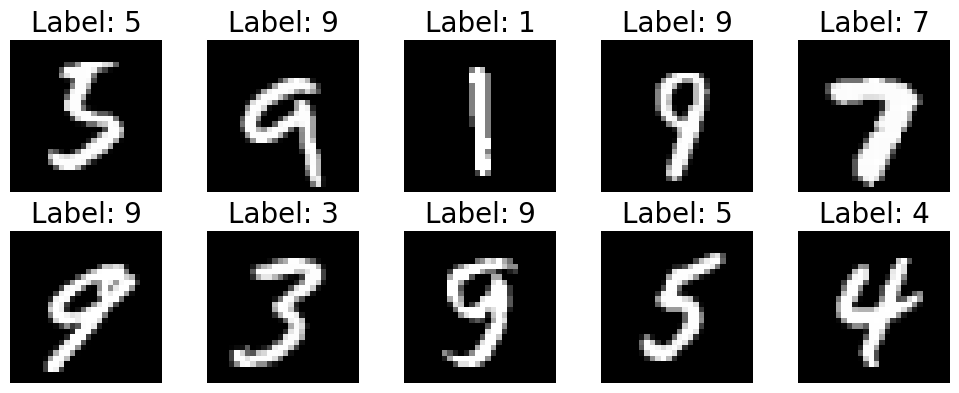

Training Data, 50.0% of which has gone through transformations:


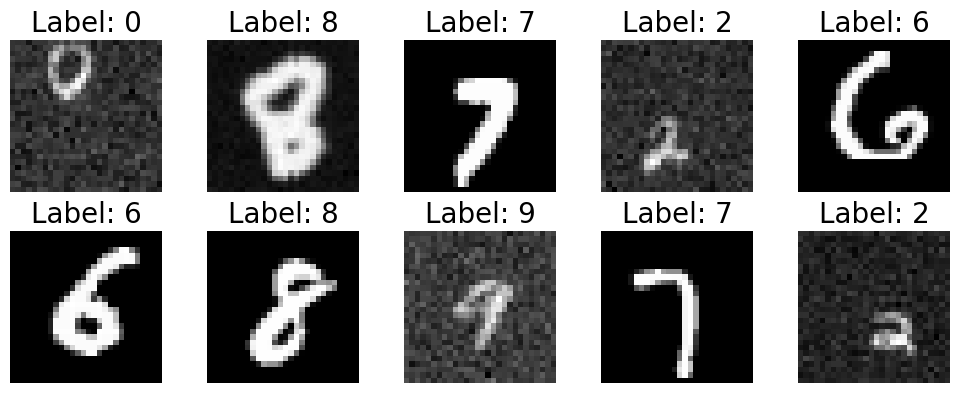

In [4]:
def show_images(images, labels, predictions=None):
    num_cols = 5
    num_rows = math.ceil(len(images) / num_cols)
    fig = plt.figure(figsize=(10, 2 * num_rows))
    for i in range(len(images)):
        ax = fig.add_subplot(num_rows, num_cols, i+1, xticks=[], yticks=[])
        if predictions is not None:
            color = "green" if predictions[i] == labels[i] else "red"
            ax.set_title(f"Label: {labels[i]}\nPred: {predictions[i]}", fontsize=20, color=color)
        else:
            ax.set_title(f"Label: {labels[i]}", fontsize=20)
        ax.axis('off')
        
        image = images[i]
        if isinstance(image, Image.Image):
            ax.imshow(image, cmap='gray')
        else:
            ax.imshow(image.squeeze().numpy(), cmap='gray')
    plt.tight_layout()
    plt.show()

print("Test Data, without transformations:")
example_images, example_labels = next(iter(simple_testloader))
show_images(example_images[:10], example_labels[:10])

print(f"Training Data, {model_options['sample_augmentation_ratio'] * 100}% of which has gone through transformations:")
example_images, example_labels = next(iter(trainloader))
show_images(example_images[:10], example_labels[:10])

### Model Infrastructure

*(see [model.py](./model.py))*

Now that we have seen what kind of data we are working with, we can build a Convolutional Neural Network.

**What is a Convolutional Neural Network?**

It's a type of neural network designed to process structured grid-like data, such as images. It's hard to "understand" what an image is if you put all the pixels in a straight line. The pixels are 2d, and they give *context* to the surrounding pixels. Convolutional Layers help solve this problem by automatically learning spatial features (like edges, textures, and objects) from the input data. It does this by sliding small focusing grids across the image called `filters`, that will look at small patches of pixels at a time, and "compress" them to extract features. For example, a filter may output a single number that indicates the likelihood of the pixels in a patch to contain an **edge**. The most important concept in these types of layers is that they COMPRESS the images into their features, REDUCING them to a much smaller set of data, which can then be passed to a regular neural network to process much more efficiently. 

**The chosen infrastructure**

The model created in [model.py](./model.py) contains two Convolutional Layers + Max Pooling Functions. These layers extract features which then get passed to two Fully Connected Layers.

Other features:
* Variable Dropout on both Fully-Connected Layers
* Adam Optimizer
* Cosine Learning Rate Scheduler
* Cross Entropy Loss Function

**Possible changes to keep in mind**

* The number of layers, their order, or their size can all be adjusted and experimented with.
* The Kernel Size or Stride of the Convolutional Layers can be changed.
* Different Optimizers could be tried.

In [5]:
import torch
from model import model_options, model, optimizer, scheduler, loss_function

# see model.py for the model architecture

print("Is cuda available?", torch.cuda.is_available())
print()
for key, value in model_options.items():
    print(f"{key.replace('_', ' ').title()}: {str(value)}")
print()
print("Model Architecture:")
print(model)


Is cuda available? True

Epochs: 3
Batch Size: 100
Eval Batch Interval: 100
Learning Rate: 0.002
Learning Rate Decay Ratio: 0.3
Weight Decay: 0.0001
Dropout: 0.2
Sample Augmentation Ratio: 0.5

Model Architecture:
Sequential(
  (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Flatten(start_dim=1, end_dim=-1)
  (7): Linear(in_features=3136, out_features=1000, bias=True)
  (8): ReLU()
  (9): Dropout(p=0.2, inplace=False)
  (10): Linear(in_features=1000, out_features=128, bias=True)
  (11): ReLU()
  (12): Dropout(p=0.2, inplace=False)
  (13): Linear(in_features=128, out_features=10, bias=True)
)


### Training Loop

Below is a simple loop that will run training and evaluation steps on the Convolutional Neural Network. We will track 6 progress indicators throughout training:
* **Training Loss**
* **Simple Evaluation Loss** - Loss on an evaluation set of *UN-AUGMENTED* data - no transformations, rotations...
* **Augmented Evaluation Loss** - Loss on an evaluation set of *AUGMENTED* data - all transformations, rotations, crops, twists...
* **Learning Rate** - how it changes over time due to the Cosine Scheduler, from a range of `100%` (the starting number) to `0%` (`0.0`)
* **Simple Accuracy** - Accuracy on the *UN-AUGMENTED* dataset
* **Augmented Accuracy** - Accuracy on the *AUGMENTED* dataset

In [6]:
from IPython import display
import time
%matplotlib inline

device_name = "cuda" if torch.cuda.is_available() else "cpu"
device = torch.device(device_name)

model.to(device)
loss_function.to(device)

num_batches = len(trainloader)

plt.ion()

fig, ax1 = plt.subplots()
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.grid(True, axis='x')
ax2 = ax1.twinx()
ax2.set_ylabel('Learning Rate (%)')
ax2.grid(True)

ax1.set_xlim(0, model_options['epochs'])
ax2.set_ylim(0, 100)
ax2.set_xlim(0, model_options['epochs'])

training_loss = {}
simple_eval_loss = {}
augmented_eval_loss = {}
learning_rates = {}
simple_accuracies = {}
augmented_accuracies = {}

t_line, = ax1.plot([], [], label='Training Loss', color='blue', marker='.')
se_line, = ax1.plot([], [], label='Simple Evaluation Loss', color='purple', marker='.')
ae_line, = ax1.plot([], [], label='Augmented Evaluation Loss', color='orange', marker='.')
lr_line, = ax2.plot([], [], label='Learning Rate', color='green', marker='.')
sa_line, = ax2.plot([], [], label='Simple Accuracy', color='red', marker='.')
aa_line, = ax2.plot([], [], label='Augmented Accuracy', color='gold', marker='.')

lines = t_line, se_line, ae_line, lr_line, sa_line, aa_line
labels = [line.get_label() for line in lines]
ax1.legend(lines, labels, bbox_to_anchor=(1.05, 1), loc='upper left')

train_progress_display = display.display(display.Markdown(""), display_id=True)
graph_display = display.display(display.Markdown("Loading..."), display_id=True)

for epoch in range(model_options['epochs']):
    training_losses = []
    model.train()
    for batch_index, (data, target) in enumerate(trainloader):
        percent_epoch = (batch_index + 1) / num_batches
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = loss_function(output, target)
        loss.backward()
        optimizer.step()
        training_losses.append(loss.item())
        
        if batch_index % model_options['eval_batch_interval'] == 0 and batch_index > 0:
            scheduler.step()
            model.eval()
            simple_test_losses = []
            augmented_test_losses = []
            with torch.no_grad():
                simple_correct = 0
                simple_total = 0
                for inputs, labels in simple_testloader:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    outputs = model(inputs)
                    _, predicted = torch.max(outputs, 1)
                    simple_total += labels.size(0)
                    simple_correct += (predicted == labels).sum().item()
                    simple_test_losses.append(loss_function(outputs, labels).item())
                    
                    training_loss[epoch + percent_epoch] = np.mean(training_losses)
                    simple_eval_loss[epoch + percent_epoch] = np.mean(simple_test_losses)
                    learning_rates[epoch + percent_epoch] = scheduler.get_last_lr()[0]
                    simple_accuracies[epoch + percent_epoch] = simple_correct / simple_total * 100
                
                augmented_correct = 0
                augmented_total = 0
                for inputs, labels in augmented_testloader:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    outputs = model(inputs)
                    _, predicted = torch.max(outputs, 1)
                    augmented_total += labels.size(0)
                    augmented_correct += (predicted == labels).sum().item()
                    augmented_test_losses.append(loss_function(outputs, labels).item())
                    
                    training_loss[epoch + percent_epoch] = np.mean(training_losses)
                    augmented_eval_loss[epoch + percent_epoch] = np.mean(augmented_test_losses)
                    learning_rates[epoch + percent_epoch] = scheduler.get_last_lr()[0]
                    augmented_accuracies[epoch + percent_epoch] = augmented_correct / augmented_total * 100
            
            train_progress_display.update(display.Markdown("\n".join([
                "* Using GPU with CUDA" if device_name == "cuda" else "Using CPU",
                f"* Epoch {epoch + 1}/{model_options['epochs']}",
                f"* Batch {batch_index}/{num_batches}",
                f"* Sample {batch_index * model_options['batch_size']}/{num_batches * model_options['batch_size']}",
                f"* Learning Rate {scheduler.get_last_lr()[0]:.2e} ({format(scheduler.get_last_lr()[0] / model_options['learning_rate'] * 100, '.2f')}%)",
                f"* Training Loss: {format(np.mean(training_losses), '.5f')}",
                f"* Simple Validation Loss: {format(np.mean(simple_test_losses), '.5f')}",
                f"* Augmented Validation Loss: {format(np.mean(augmented_test_losses), '.5f')}",
                f"* Simple Accuracy: {format(100 * simple_correct / simple_total, '.2f')}% {simple_correct}/{simple_total}",
                f"* Augmented Accuracy: {format(100 * augmented_correct / augmented_total, '.2f')}% {augmented_correct}/{augmented_total}",
            ])))
            time.sleep(1.0)
            
            t_line.set_xdata(list(training_loss.keys()))
            t_line.set_ydata(list(training_loss.values()))
            se_line.set_xdata(list(simple_eval_loss.keys()))
            se_line.set_ydata(list(simple_eval_loss.values()))
            ae_line.set_xdata(list(augmented_eval_loss.keys()))
            ae_line.set_ydata(list(augmented_eval_loss.values()))
            lr_line.set_xdata(list(learning_rates.keys()))
            lr_line.set_ydata(list([round(r / model_options['learning_rate'] * 100, 2) for r in learning_rates.values()]))
            sa_line.set_xdata(list(simple_accuracies.keys()))
            sa_line.set_ydata(list(simple_accuracies.values()))
            aa_line.set_xdata(list(augmented_accuracies.keys()))
            aa_line.set_ydata(list(augmented_accuracies.values()))

            ax1.relim()
            ax1.autoscale_view()

            plt.draw()
            graph_display.update(plt.gcf())
            time.sleep(1.0)

plt.close(fig)

print("Finished training")

* Using GPU with CUDA
* Epoch 3/3
* Batch 500/600
* Sample 50000/60000
* Learning Rate 6.94e-04 (34.69%)
* Training Loss: 0.26355
* Simple Validation Loss: 0.03216
* Augmented Validation Loss: 0.40725
* Simple Accuracy: 98.96% 9896/10000
* Augmented Accuracy: 86.89% 8689/10000

Loading...

Finished training


### After Training - Evaluation
Now that training is finished, we can use our model to look at some its predictions and see how it works with our own eyes. We can also look at some of the samples it got *WRONG* - so we can understand a little of its weaknesses.

In [7]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

device_name = "cuda" if torch.cuda.is_available() else "cpu"
print("Using GPU with CUDA" if device_name == "cuda" else "Using CPU")
device = torch.device(device_name)

# show some predictions
model.eval()

print("Simple Unaugmented Test Data:")
images, labels = next(iter(simple_testloader))
images = images[:25]
labels = labels[:25]
images = images.to(device)
labels = labels.to(device)
outputs = model(images)
_, predictions = torch.max(outputs, 1)
show_images(images.cpu(), labels.cpu(), predictions.cpu())

# predict on test dataset
y_true = []
y_pred = []
with torch.no_grad():
    for inputs, labels in simple_testloader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

conf_matrix = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

print("Augmented Test Data:")
images, labels = next(iter(augmented_testloader))
images = images[:25]
labels = labels[:25]
images = images.to(device)
labels = labels.to(device)
outputs = model(images)
_, predictions = torch.max(outputs, 1)
show_images(images.cpu(), labels.cpu(), predictions.cpu())

# predict on test dataset
y_true = []
y_pred = []
with torch.no_grad():
    for inputs, labels in augmented_testloader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

conf_matrix = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

ModuleNotFoundError: No module named 'seaborn'

Simple Unaugmented Incorrect Predictions:


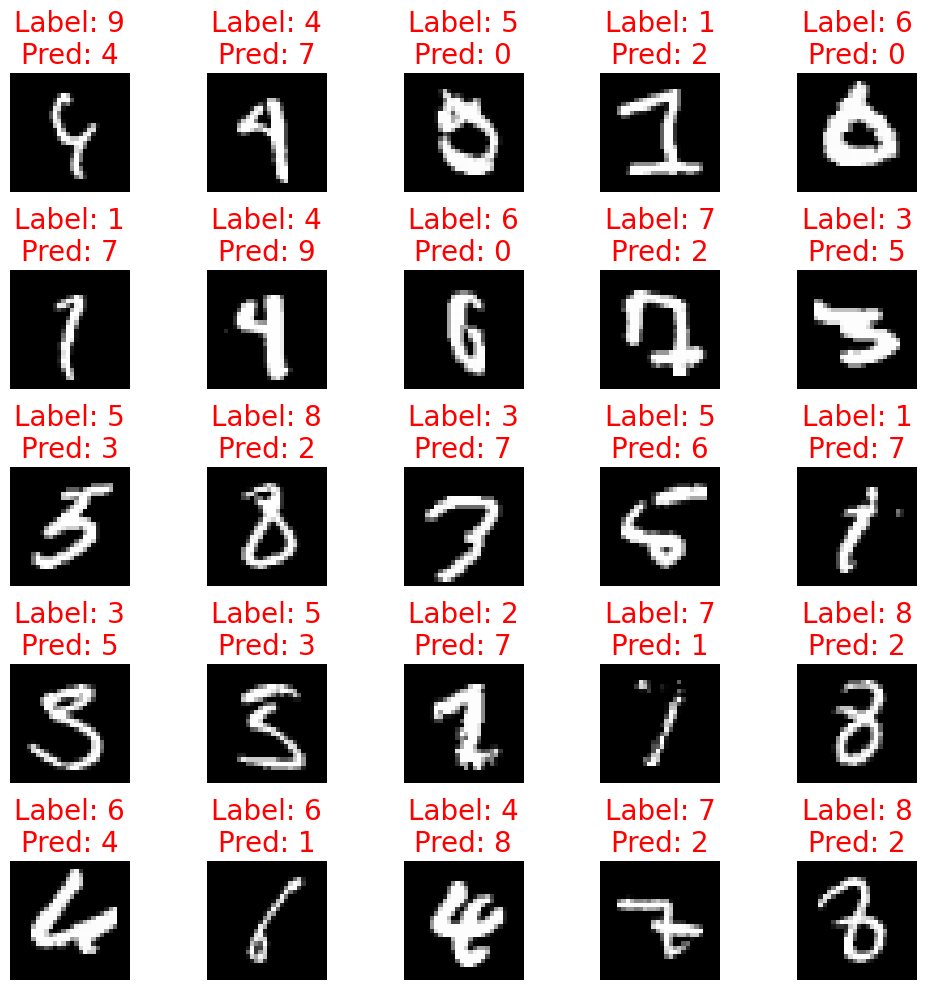

Augmented Incorrect Predictions:


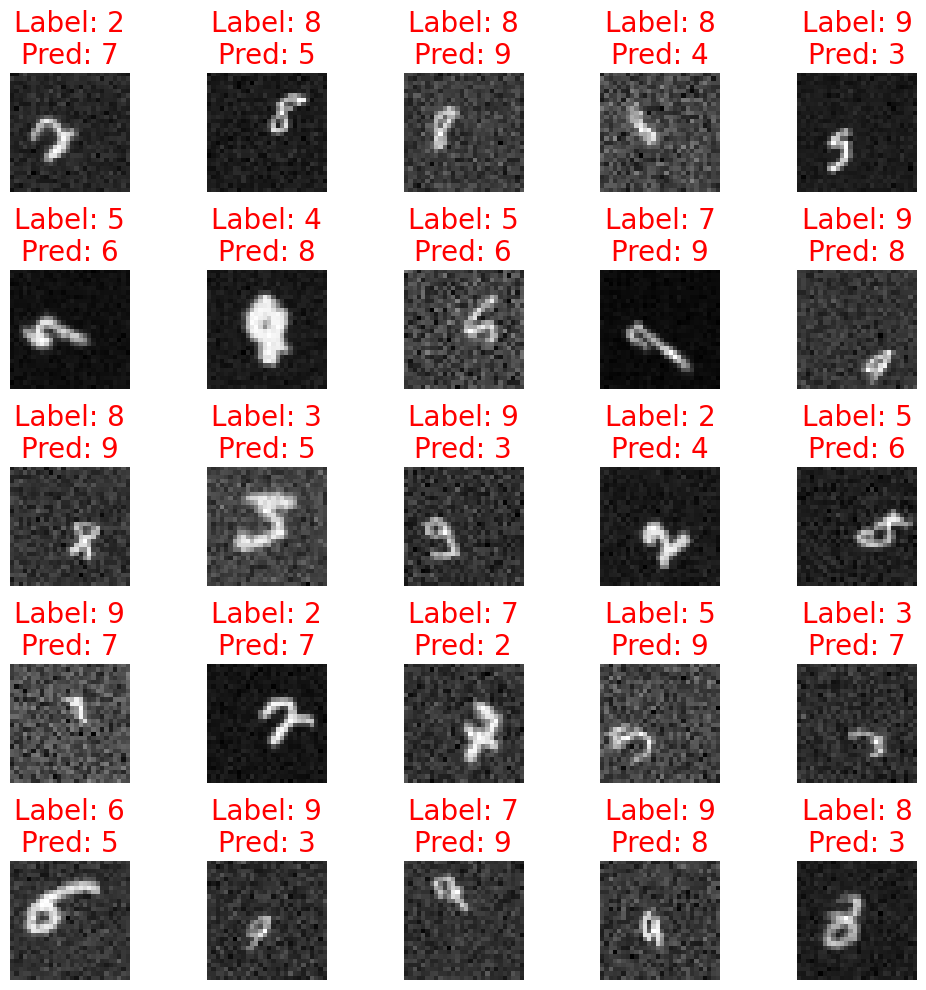

In [9]:
# show the first 25 INCORRECT predictions
print("Simple Unaugmented Incorrect Predictions:")
incorrect_images = []
incorrect_labels = []
incorrect_predictions = []
for i, (inputs, labels) in enumerate(simple_testloader):
    inputs = inputs.to(device)
    labels = labels.to(device)
    outputs = model(inputs)
    _, predicted = torch.max(outputs, 1)
    for j in range(len(labels)):
        if predicted[j] != labels[j]:
            incorrect_images.append(inputs[j].cpu())
            incorrect_labels.append(labels[j].cpu())
            incorrect_predictions.append(predicted[j].cpu())
    if len(incorrect_images) >= 25:
        break

show_images(incorrect_images[:25], incorrect_labels[:25], incorrect_predictions[:25])

print("Augmented Incorrect Predictions:")
incorrect_images = []
incorrect_labels = []
incorrect_predictions = []
for i, (inputs, labels) in enumerate(augmented_testloader):
    inputs = inputs.to(device)
    labels = labels.to(device)
    outputs = model(inputs)
    _, predicted = torch.max(outputs, 1)
    for j in range(len(labels)):
        if predicted[j] != labels[j]:
            incorrect_images.append(inputs[j].cpu())
            incorrect_labels.append(labels[j].cpu())
            incorrect_predictions.append(predicted[j].cpu())
    if len(incorrect_images) >= 25:
        break

show_images(incorrect_images[:25], incorrect_labels[:25], incorrect_predictions[:25])

In [10]:
# save the model
torch.save(model.state_dict(), "models/model.pth")

# What Next?
### You could keep tweaking the hyperparameters by hand to get a better score.
This would be very time-consuming, however, and quite frustrating. Most of the time, it is not clear what will make a model more efficient.

### Let's Improve Even More!
Instead of a manual tweaking process, we can algorithmically alter the model to find even better combinations of hyperparameters. Go to the [Random Search Notebook](./search.ipynb) to learn more!